In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
import scipy
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_net
import ring_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

# Get best fit parameters

In [26]:
id = (133, 0)
with open('./../results/results_ring_'+str(id[0])+'.pkl', 'rb') as handle:
    res_dict = pickle.load(handle)[id[1]]
    prms = res_dict['prms']
    eX = res_dict['best_monk_eX']
    bX = res_dict['best_monk_bX']
    aXs = res_dict['best_monk_aXs']
    K = prms['K']
    SoriE = prms['SoriE']
    SoriI = prms['SoriI']
    SoriF = prms['SoriF']
    J = prms['J']
#     beta = prms['beta']
#     gE = prms['gE']
#     gI = prms['gI']
#     hE = prms['hE']
#     hI = prms['hI']
    L = prms['L']
#     CVL = prms['CVL']

ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')
ri.set_up_nonlinearity_tensor()

NtE = 50
Nt = NtE*ri.tE
dt = ri.tI/5
T = torch.linspace(0,8*Nt,round(8*Nt/dt)+1)
mask_time = T>(4*Nt)
T_mask = T.cpu().numpy()[mask_time]

N = 50000
Nori = 20
NE = 4*(N//Nori)//5
NI = 1*(N//Nori)//5

this_prms = prms.copy()
this_prms['Nori'] = Nori
this_prms['NE'] = NE
this_prms['NI'] = NI

Loading previously saved nonlinearity
Using cpu


# Simulate unstructured network, where peak input goes to all locations

In [4]:
reload(su)

start = time.process_time()

net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,this_prms,eX)

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

base_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True)
base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
base_dynas = base_sol[:,mask_time].cpu().numpy()

np.save('unstruct_base_sol',base_sol.cpu().numpy())

print("Integrating base network took ",time.process_time() - start," s")
print('')

start = time.process_time()

opto_sol,_ = integ.sim_dyn_tensor(ri,T,1.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True)
opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
opto_dynas = opto_sol[:,mask_time].cpu().numpy()

np.save('unstruct_opto_sol',opto_sol.cpu().numpy())

print("Integrating opto network took ",time.process_time() - start," s")
print('')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base_sol = torch.from_numpy(np.load('unstruct_base_sol.npy')).to(device)
# base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
# base_dynas = base_sol[:,mask_time].cpu().numpy()
# opto_sol = torch.from_numpy(np.load('unstruct_opto_sol.npy')).to(device)
# opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
# opto_dynas = opto_sol[:,mask_time].cpu().numpy()

Using cpu
Generating disorder took  6.104083999999999  s

Integrating base network took  1173.115717  s

Integrating opto network took  1118.7335600000001  s



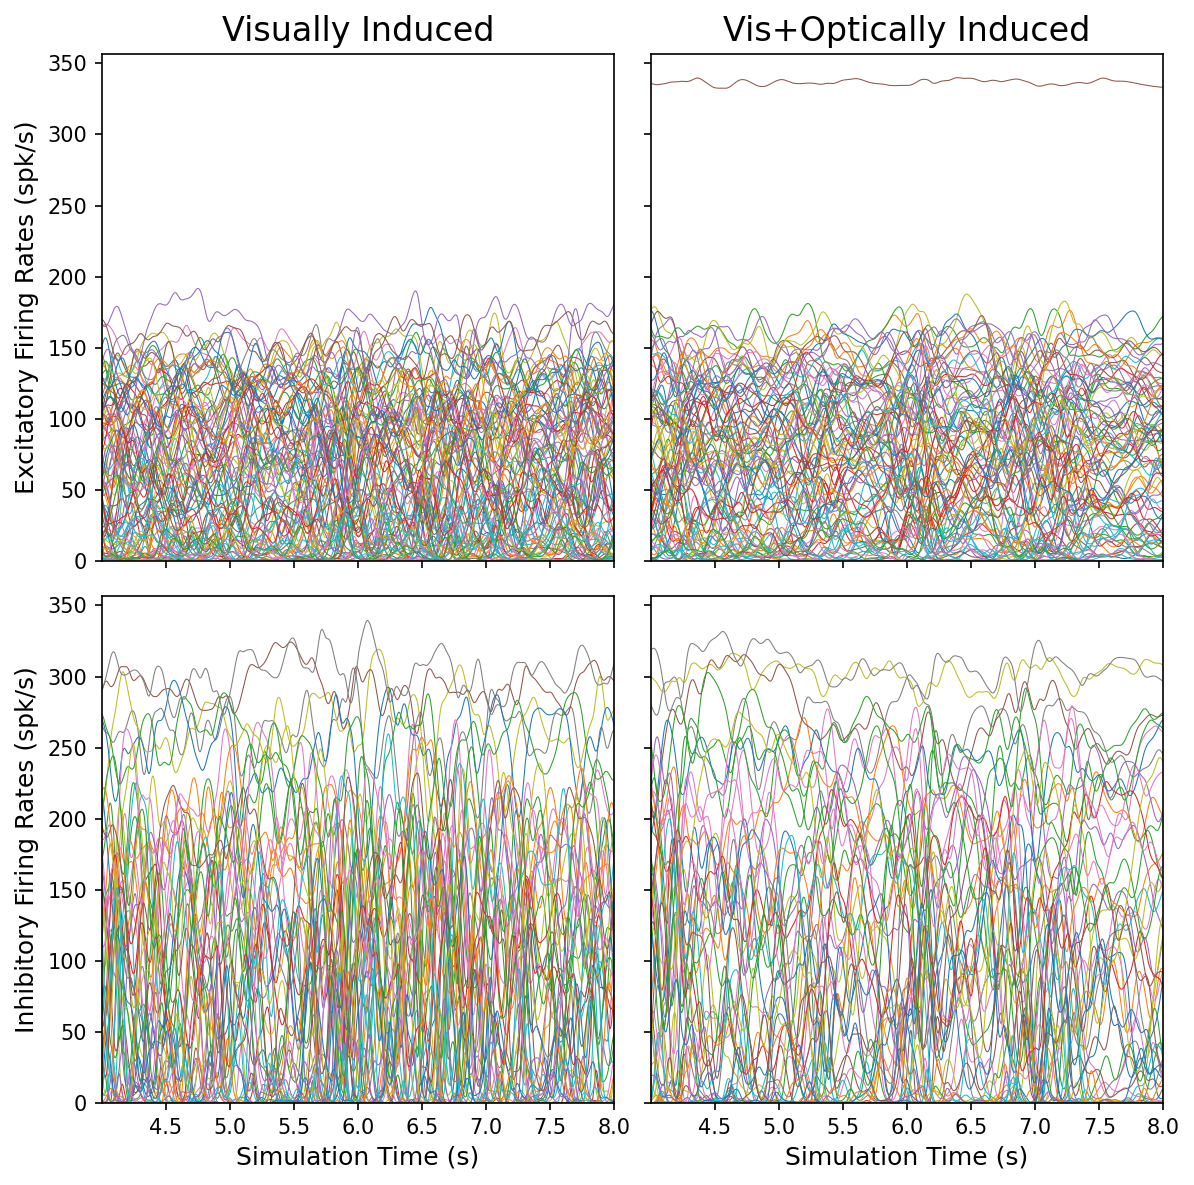

In [5]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

axs[0,0].plot(T_mask,base_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[0,1].plot(T_mask,opto_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[1,0].plot(T_mask,base_dynas[net.C_all[1],:][::20,:].T,lw=0.5)
axs[1,1].plot(T_mask,opto_dynas[net.C_all[1],:][::20,:].T,lw=0.5)

axs[0,0].set_xlim(min(T_mask),max(T_mask))
axs[0,0].set_ylim(0,None)

axs[1,0].set_xlabel('Simulation Time (s)',fontsize=12)
axs[1,1].set_xlabel('Simulation Time (s)',fontsize=12)

axs[0,0].set_ylabel('Excitatory Firing Rates (spk/s)',fontsize=12)
axs[1,0].set_ylabel('Inhibitory Firing Rates (spk/s)',fontsize=12)

axs[0,0].set_title('Visually Induced',fontsize=16)
axs[0,1].set_title('Vis+Optically Induced',fontsize=16)

fig.tight_layout()

In [6]:
print(np.mean(base_rates))
print(np.mean(opto_rates))
print(np.mean(opto_rates-base_rates))
print()
print(np.std(base_rates))
print(np.std(opto_rates))
print(np.std(opto_rates-base_rates))
print()
print(np.cov(base_rates,opto_rates-base_rates)[0,1] / np.var(opto_rates-base_rates))

57.52335
59.7337
2.2103486

57.211678
60.96954
21.53654

-0.021253210356733575


# Find level of increased disorder that gives reshuffling

In [7]:
disord_factor = 2.0

disord_prms = this_prms.copy()
disord_prms['K'] = int(this_prms['K']/disord_factor)
disord_prms['J'] = this_prms['J']*(this_prms['K']/disord_prms['K'])

reload(su)

start = time.process_time()

net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,disord_prms,eX)
# net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,disord_prms,eX*disord_factor)

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

base_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True,max_min=60)
base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
base_dynas = base_sol[:,mask_time].cpu().numpy()

np.save('unstruct_base_sol_more_disord',base_sol.cpu().numpy())

print("Integrating base network took ",time.process_time() - start," s")
print('')

start = time.process_time()

opto_sol,_ = integ.sim_dyn_tensor(ri,T,1.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True,max_min=60)
opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
opto_dynas = opto_sol[:,mask_time].cpu().numpy()
np.save('unstruct_opto_sol_more_disord',opto_sol.cpu().numpy())

print("Integrating opto network took ",time.process_time() - start," s")
print('')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base_sol = torch.from_numpy(np.load('unstruct_base_sol_more_disord.npy')).to(device)
# base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
# base_dynas = base_sol[:,mask_time].cpu().numpy()
# opto_sol = torch.from_numpy(np.load('unstruct_opto_sol_more_disord.npy')).to(device)
# opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
# opto_dynas = opto_sol[:,mask_time].cpu().numpy()

Using cpu
Generating disorder took  5.918745999999828  s

Integrating base network took  2007.679779  s

Integrating opto network took  2280.661354  s



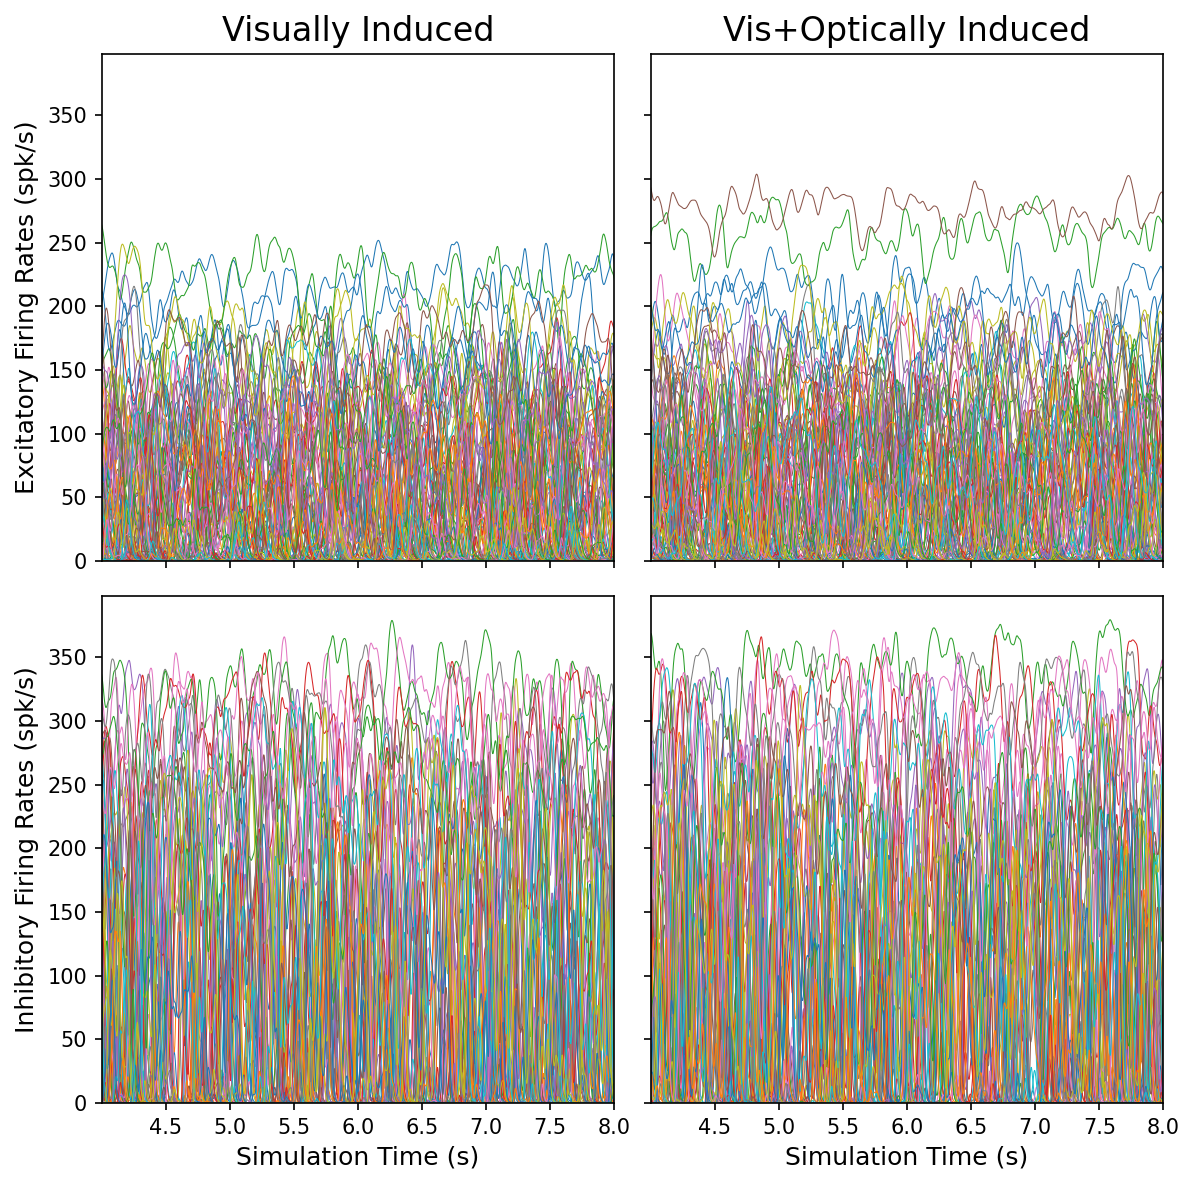

In [8]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

axs[0,0].plot(T_mask,base_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[0,1].plot(T_mask,opto_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[1,0].plot(T_mask,base_dynas[net.C_all[1],:][::20,:].T,lw=0.5)
axs[1,1].plot(T_mask,opto_dynas[net.C_all[1],:][::20,:].T,lw=0.5)

axs[0,0].set_xlim(min(T_mask),max(T_mask))
axs[0,0].set_ylim(0,None)

axs[1,0].set_xlabel('Simulation Time (s)',fontsize=12)
axs[1,1].set_xlabel('Simulation Time (s)',fontsize=12)

axs[0,0].set_ylabel('Excitatory Firing Rates (spk/s)',fontsize=12)
axs[1,0].set_ylabel('Inhibitory Firing Rates (spk/s)',fontsize=12)

axs[0,0].set_title('Visually Induced',fontsize=16)
axs[0,1].set_title('Vis+Optically Induced',fontsize=16)

fig.tight_layout()

In [9]:
print(np.mean(base_rates))
print(np.mean(opto_rates))
print(np.mean(opto_rates-base_rates))
print()
print(np.std(base_rates))
print(np.std(opto_rates))
print(np.std(opto_rates-base_rates))
print()
print(np.cov(base_rates,opto_rates-base_rates)[0,1] / np.var(opto_rates-base_rates))

53.751568
56.171364
2.4197912

59.739685
62.763695
21.906948

-0.11405568861055522


In [10]:
disord_factor = 2.0

disord_prms = this_prms.copy()
disord_prms['K'] = int(this_prms['K']/disord_factor)
disord_prms['J'] = this_prms['J']*(this_prms['K']/disord_prms['K'])

reload(su)

start = time.process_time()

# net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,disord_prms,eX)
net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,disord_prms,eX*disord_factor)

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

base_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True,max_min=60)
base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
base_dynas = base_sol[:,mask_time].cpu().numpy()

np.save('unstruct_base_sol_more_disord',base_sol.cpu().numpy())

print("Integrating base network took ",time.process_time() - start," s")
print('')

start = time.process_time()

opto_sol,_ = integ.sim_dyn_tensor(ri,T,1.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True,max_min=60)
opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
opto_dynas = opto_sol[:,mask_time].cpu().numpy()
np.save('unstruct_opto_sol_more_disord',opto_sol.cpu().numpy())

print("Integrating opto network took ",time.process_time() - start," s")
print('')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base_sol = torch.from_numpy(np.load('unstruct_base_sol_more_disord.npy')).to(device)
# base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
# base_dynas = base_sol[:,mask_time].cpu().numpy()
# opto_sol = torch.from_numpy(np.load('unstruct_opto_sol_more_disord.npy')).to(device)
# opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
# opto_dynas = opto_sol[:,mask_time].cpu().numpy()

Using cpu
Generating disorder took  6.896883999999773  s

Integrating base network took  2264.1785929999996  s

Integrating opto network took  2232.730813  s



In [11]:
print(np.mean(base_rates))
print(np.mean(opto_rates))
print(np.mean(opto_rates-base_rates))
print()
print(np.std(base_rates))
print(np.std(opto_rates))
print(np.std(opto_rates-base_rates))
print()
print(np.cov(base_rates,opto_rates-base_rates)[0,1] / np.var(opto_rates-base_rates))

54.2666
56.650368
2.383768

60.886368
64.00774
21.359632

-0.07276941552049754


# Read and Plot Cluster Results

In [4]:
structs = np.arange(0,8+1)/8
disords = 3**(np.arange(0,8+1)/8)

print(structs)
print(disords)

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
[1.         1.14720269 1.31607401 1.50980365 1.73205081 1.98701335
 2.27950706 2.61505663 3.        ]


In [19]:
all_base_means = np.zeros((len(structs),len(disords)))
all_base_stds = np.zeros((len(structs),len(disords)))
all_opto_means = np.zeros((len(structs),len(disords)))
all_opto_stds = np.zeros((len(structs),len(disords)))
all_diff_means = np.zeros((len(structs),len(disords)))
all_diff_stds = np.zeros((len(structs),len(disords)))
all_norm_covs = np.zeros((len(structs),len(disords)))
vsm_base_means = np.zeros((len(structs),len(disords)))
vsm_base_stds = np.zeros((len(structs),len(disords)))
vsm_opto_means = np.zeros((len(structs),len(disords)))
vsm_opto_stds = np.zeros((len(structs),len(disords)))
vsm_diff_means = np.zeros((len(structs),len(disords)))
vsm_diff_stds = np.zeros((len(structs),len(disords)))
vsm_norm_covs = np.zeros((len(structs),len(disords)))
timeouts = np.zeros((len(structs),len(disords),50))

for struct_idx,struct in enumerate(structs):
    for disord_idx,disord in enumerate(disords):
        with open('./../results/vary_struct_{:d}_disord_{:d}'.format(struct_idx,disord_idx)+'.pkl', 'rb') as\
                handle:
            res_dict = pickle.load(handle)
        
        all_base_means[struct_idx,disord_idx] = res_dict['all_base_means']
        all_base_stds[struct_idx,disord_idx] = res_dict['all_base_stds']
        all_opto_means[struct_idx,disord_idx] = res_dict['all_opto_means']
        all_opto_stds[struct_idx,disord_idx] = res_dict['all_opto_stds']
        all_diff_means[struct_idx,disord_idx] = res_dict['all_diff_means']
        all_diff_stds[struct_idx,disord_idx] = res_dict['all_diff_stds']
        all_norm_covs[struct_idx,disord_idx] = res_dict['all_norm_covs']
        vsm_base_means[struct_idx,disord_idx] = res_dict['vsm_base_means']
        vsm_base_stds[struct_idx,disord_idx] = res_dict['vsm_base_stds']
        vsm_opto_means[struct_idx,disord_idx] = res_dict['vsm_opto_means']
        vsm_opto_stds[struct_idx,disord_idx] = res_dict['vsm_opto_stds']
        vsm_diff_means[struct_idx,disord_idx] = res_dict['vsm_diff_means']
        vsm_diff_stds[struct_idx,disord_idx] = res_dict['vsm_diff_stds']
        vsm_norm_covs[struct_idx,disord_idx] = res_dict['vsm_norm_covs']
        timeouts[struct_idx,disord_idx] = res_dict['timeouts']

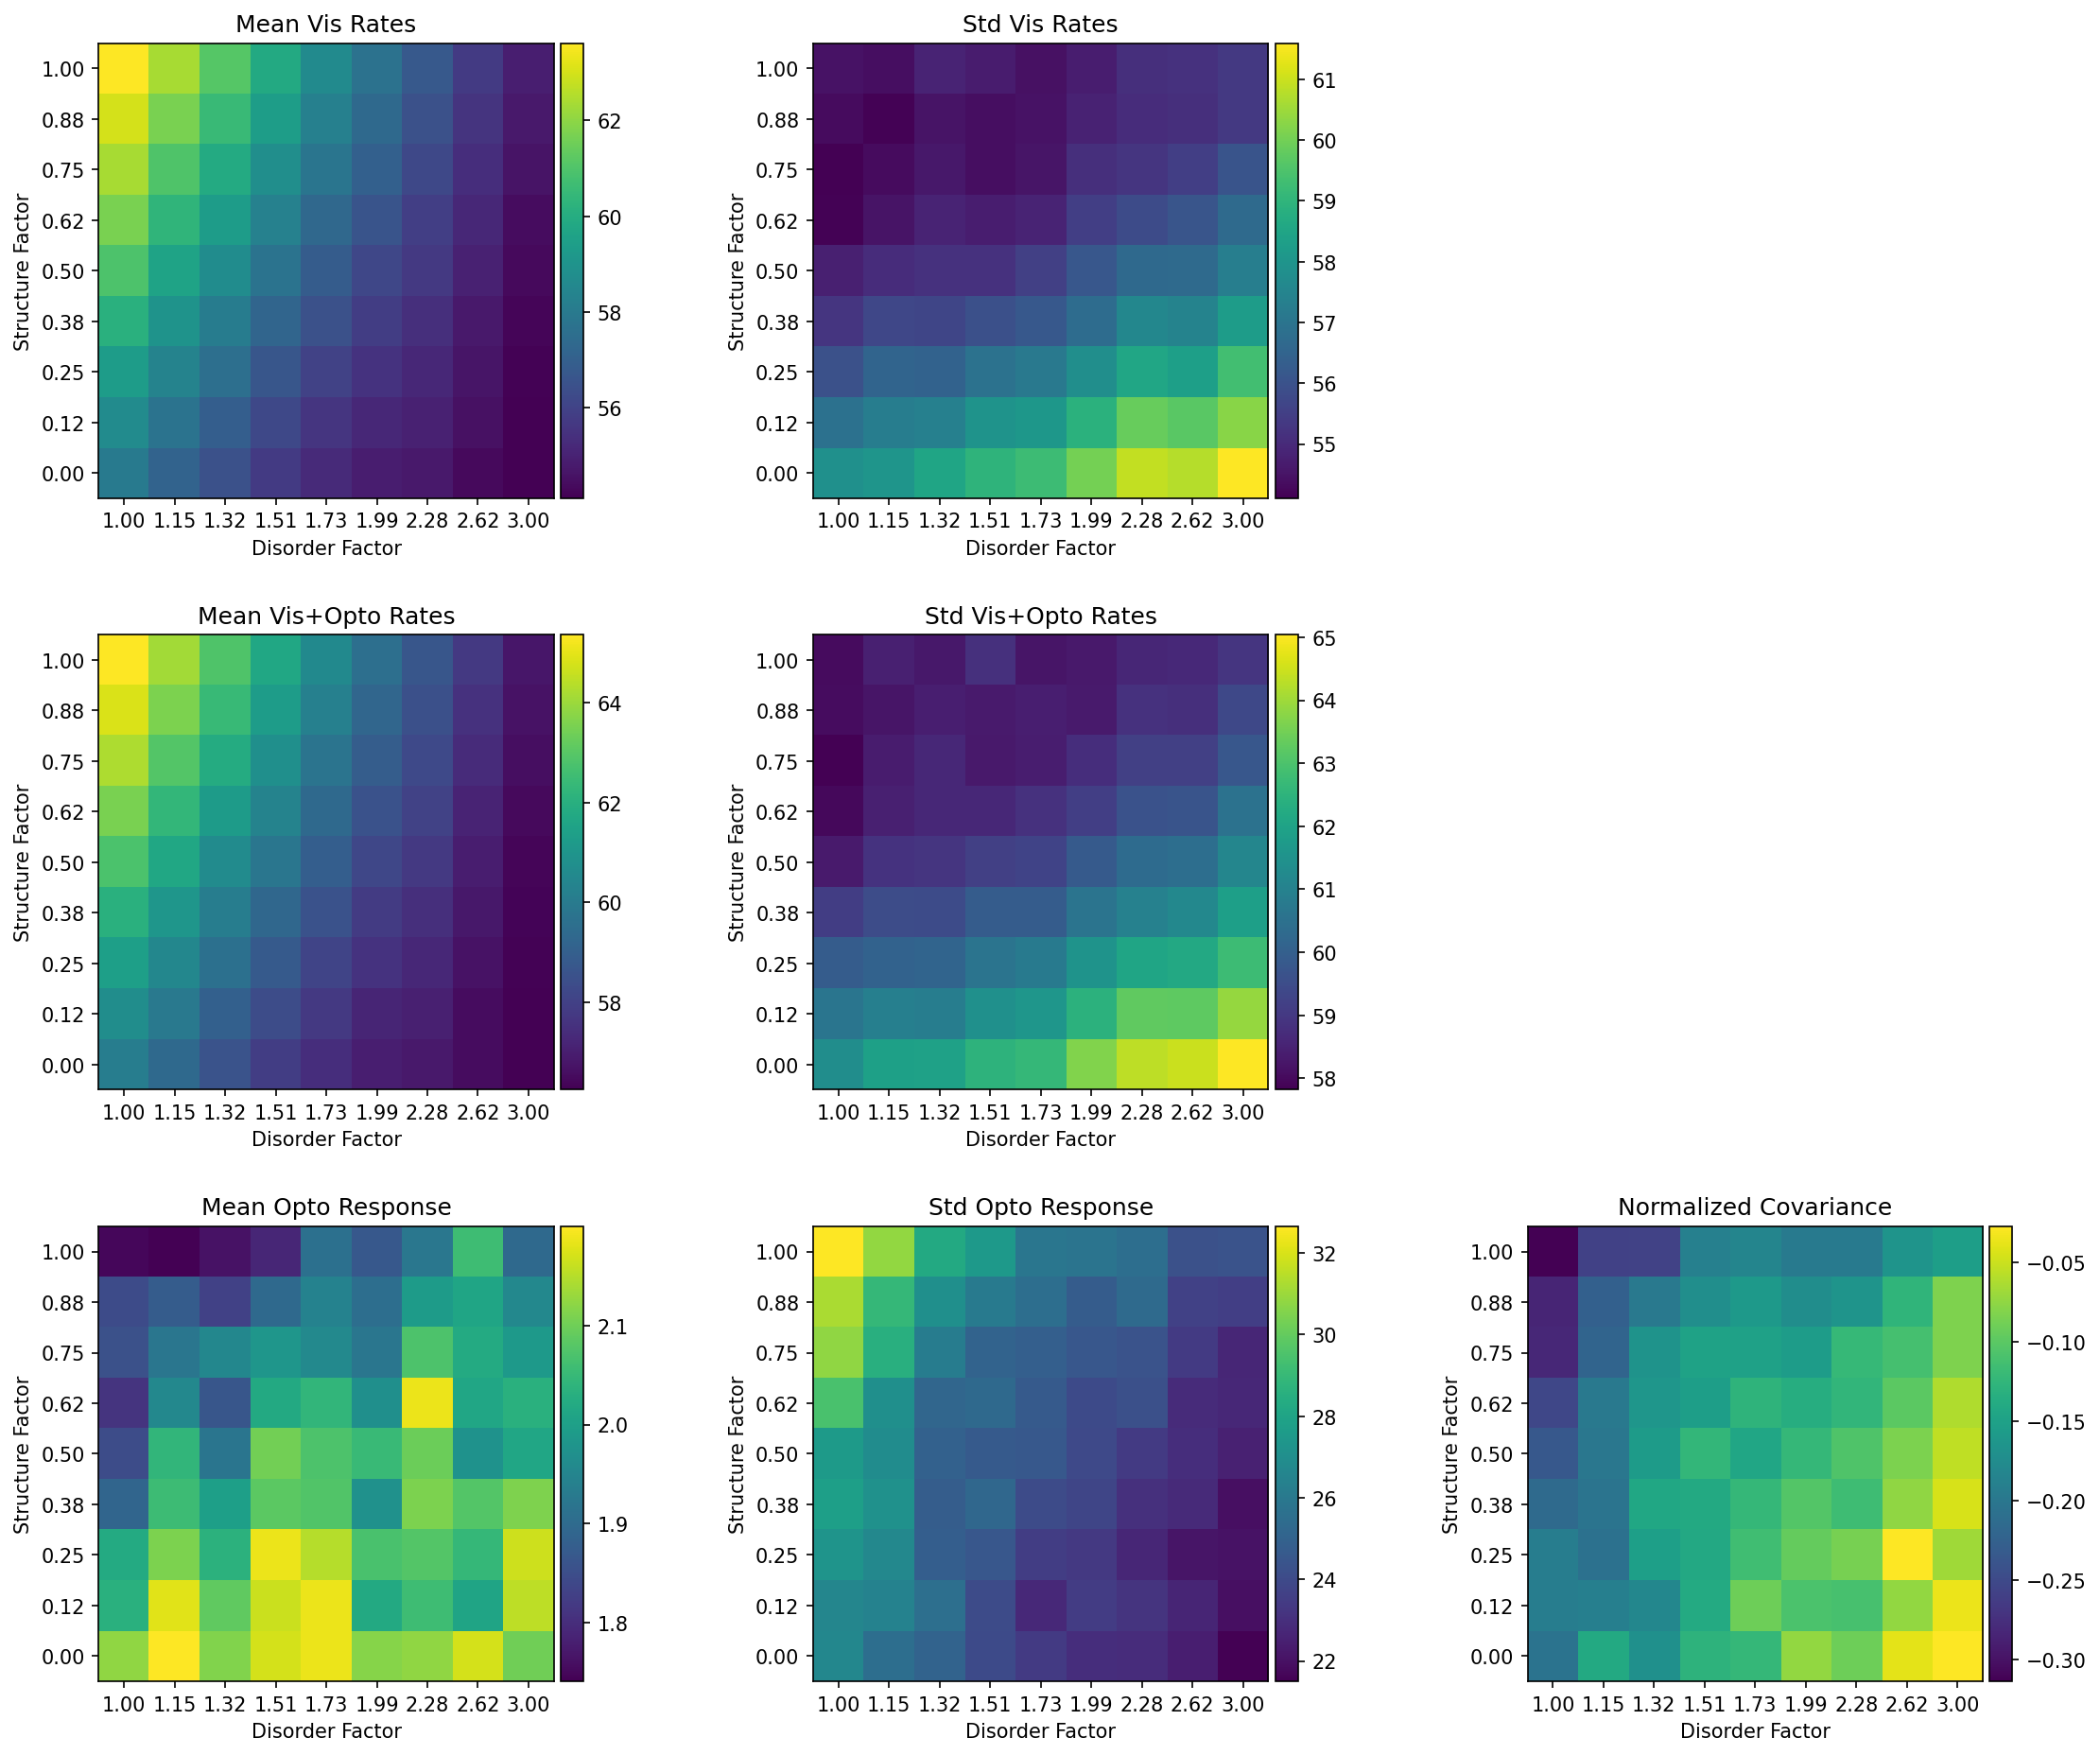

In [16]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],vsm_base_means,origin='lower')
imshowbar(fig,axs[0,1],vsm_base_stds,origin='lower')
imshowbar(fig,axs[1,0],vsm_opto_means,origin='lower')
imshowbar(fig,axs[1,1],vsm_opto_stds,origin='lower')
imshowbar(fig,axs[2,0],vsm_diff_means,origin='lower')
imshowbar(fig,axs[2,1],vsm_diff_stds,origin='lower')
imshowbar(fig,axs[2,2],vsm_norm_covs,origin='lower')

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
            axs[i,j].set_xticks(np.arange(len(disords)),['{:.2f}'.format(disord) for disord in disords],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('Disorder Factor')
            axs[i,j].set_ylabel('Structure Factor')

# Read and plot struct vs J results

In [27]:
structs = np.arange(0,8+1)/8
Js = prms['J']*3**(np.arange(0,8+1)/8)

print(structs)
print(Js)

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
[0.00014202 0.00016293 0.00018691 0.00021442 0.00024599 0.0002822
 0.00032374 0.00037139 0.00042606]


In [85]:
all_base_means = np.zeros((len(structs),len(Js)))
all_base_stds = np.zeros((len(structs),len(Js)))
all_opto_means = np.zeros((len(structs),len(Js)))
all_opto_stds = np.zeros((len(structs),len(Js)))
all_diff_means = np.zeros((len(structs),len(Js)))
all_diff_stds = np.zeros((len(structs),len(Js)))
all_norm_covs = np.zeros((len(structs),len(Js)))
vsm_base_means = np.zeros((len(structs),len(Js)))
vsm_base_stds = np.zeros((len(structs),len(Js)))
vsm_opto_means = np.zeros((len(structs),len(Js)))
vsm_opto_stds = np.zeros((len(structs),len(Js)))
vsm_diff_means = np.zeros((len(structs),len(Js)))
vsm_diff_stds = np.zeros((len(structs),len(Js)))
vsm_norm_covs = np.zeros((len(structs),len(Js)))
Lexps = np.zeros((len(structs),len(Js),2))
timeouts = np.zeros((len(structs),len(Js),2))

for struct_idx,struct in enumerate(structs):
    for J_idx,J in enumerate(Js):
        try:
            with open('./../results/vary_struct_{:d}_J_{:d}'.format(struct_idx,J_idx)+'.pkl', 'rb') as\
                    handle:
                res_dict = pickle.load(handle)

            all_base_means[struct_idx,J_idx] = res_dict['all_base_means']
            all_base_stds[struct_idx,J_idx] = res_dict['all_base_stds']
            all_opto_means[struct_idx,J_idx] = res_dict['all_opto_means']
            all_opto_stds[struct_idx,J_idx] = res_dict['all_opto_stds']
            all_diff_means[struct_idx,J_idx] = res_dict['all_diff_means']
            all_diff_stds[struct_idx,J_idx] = res_dict['all_diff_stds']
            all_norm_covs[struct_idx,J_idx] = res_dict['all_norm_covs']
            vsm_base_means[struct_idx,J_idx] = res_dict['vsm_base_means']
            vsm_base_stds[struct_idx,J_idx] = res_dict['vsm_base_stds']
            vsm_opto_means[struct_idx,J_idx] = res_dict['vsm_opto_means']
            vsm_opto_stds[struct_idx,J_idx] = res_dict['vsm_opto_stds']
            vsm_diff_means[struct_idx,J_idx] = res_dict['vsm_diff_means']
            vsm_diff_stds[struct_idx,J_idx] = res_dict['vsm_diff_stds']
            vsm_norm_covs[struct_idx,J_idx] = res_dict['vsm_norm_covs']
            Lexps[struct_idx,J_idx] = np.median(res_dict['Lexps'],-2)
            timeouts[struct_idx,J_idx] = np.sum(res_dict['timeouts'],-2)
            
        except:
            all_base_means[struct_idx,J_idx] = np.nan
            all_base_stds[struct_idx,J_idx] = np.nan
            all_opto_means[struct_idx,J_idx] = np.nan
            all_opto_stds[struct_idx,J_idx] = np.nan
            all_diff_means[struct_idx,J_idx] = np.nan
            all_diff_stds[struct_idx,J_idx] = np.nan
            all_norm_covs[struct_idx,J_idx] = np.nan
            vsm_base_means[struct_idx,J_idx] = np.nan
            vsm_base_stds[struct_idx,J_idx] = np.nan
            vsm_opto_means[struct_idx,J_idx] = np.nan
            vsm_opto_stds[struct_idx,J_idx] = np.nan
            vsm_diff_means[struct_idx,J_idx] = np.nan
            vsm_diff_stds[struct_idx,J_idx] = np.nan
            vsm_norm_covs[struct_idx,J_idx] = np.nan
            Lexps[struct_idx,J_idx] = np.nan
            timeouts[struct_idx,J_idx] = 0

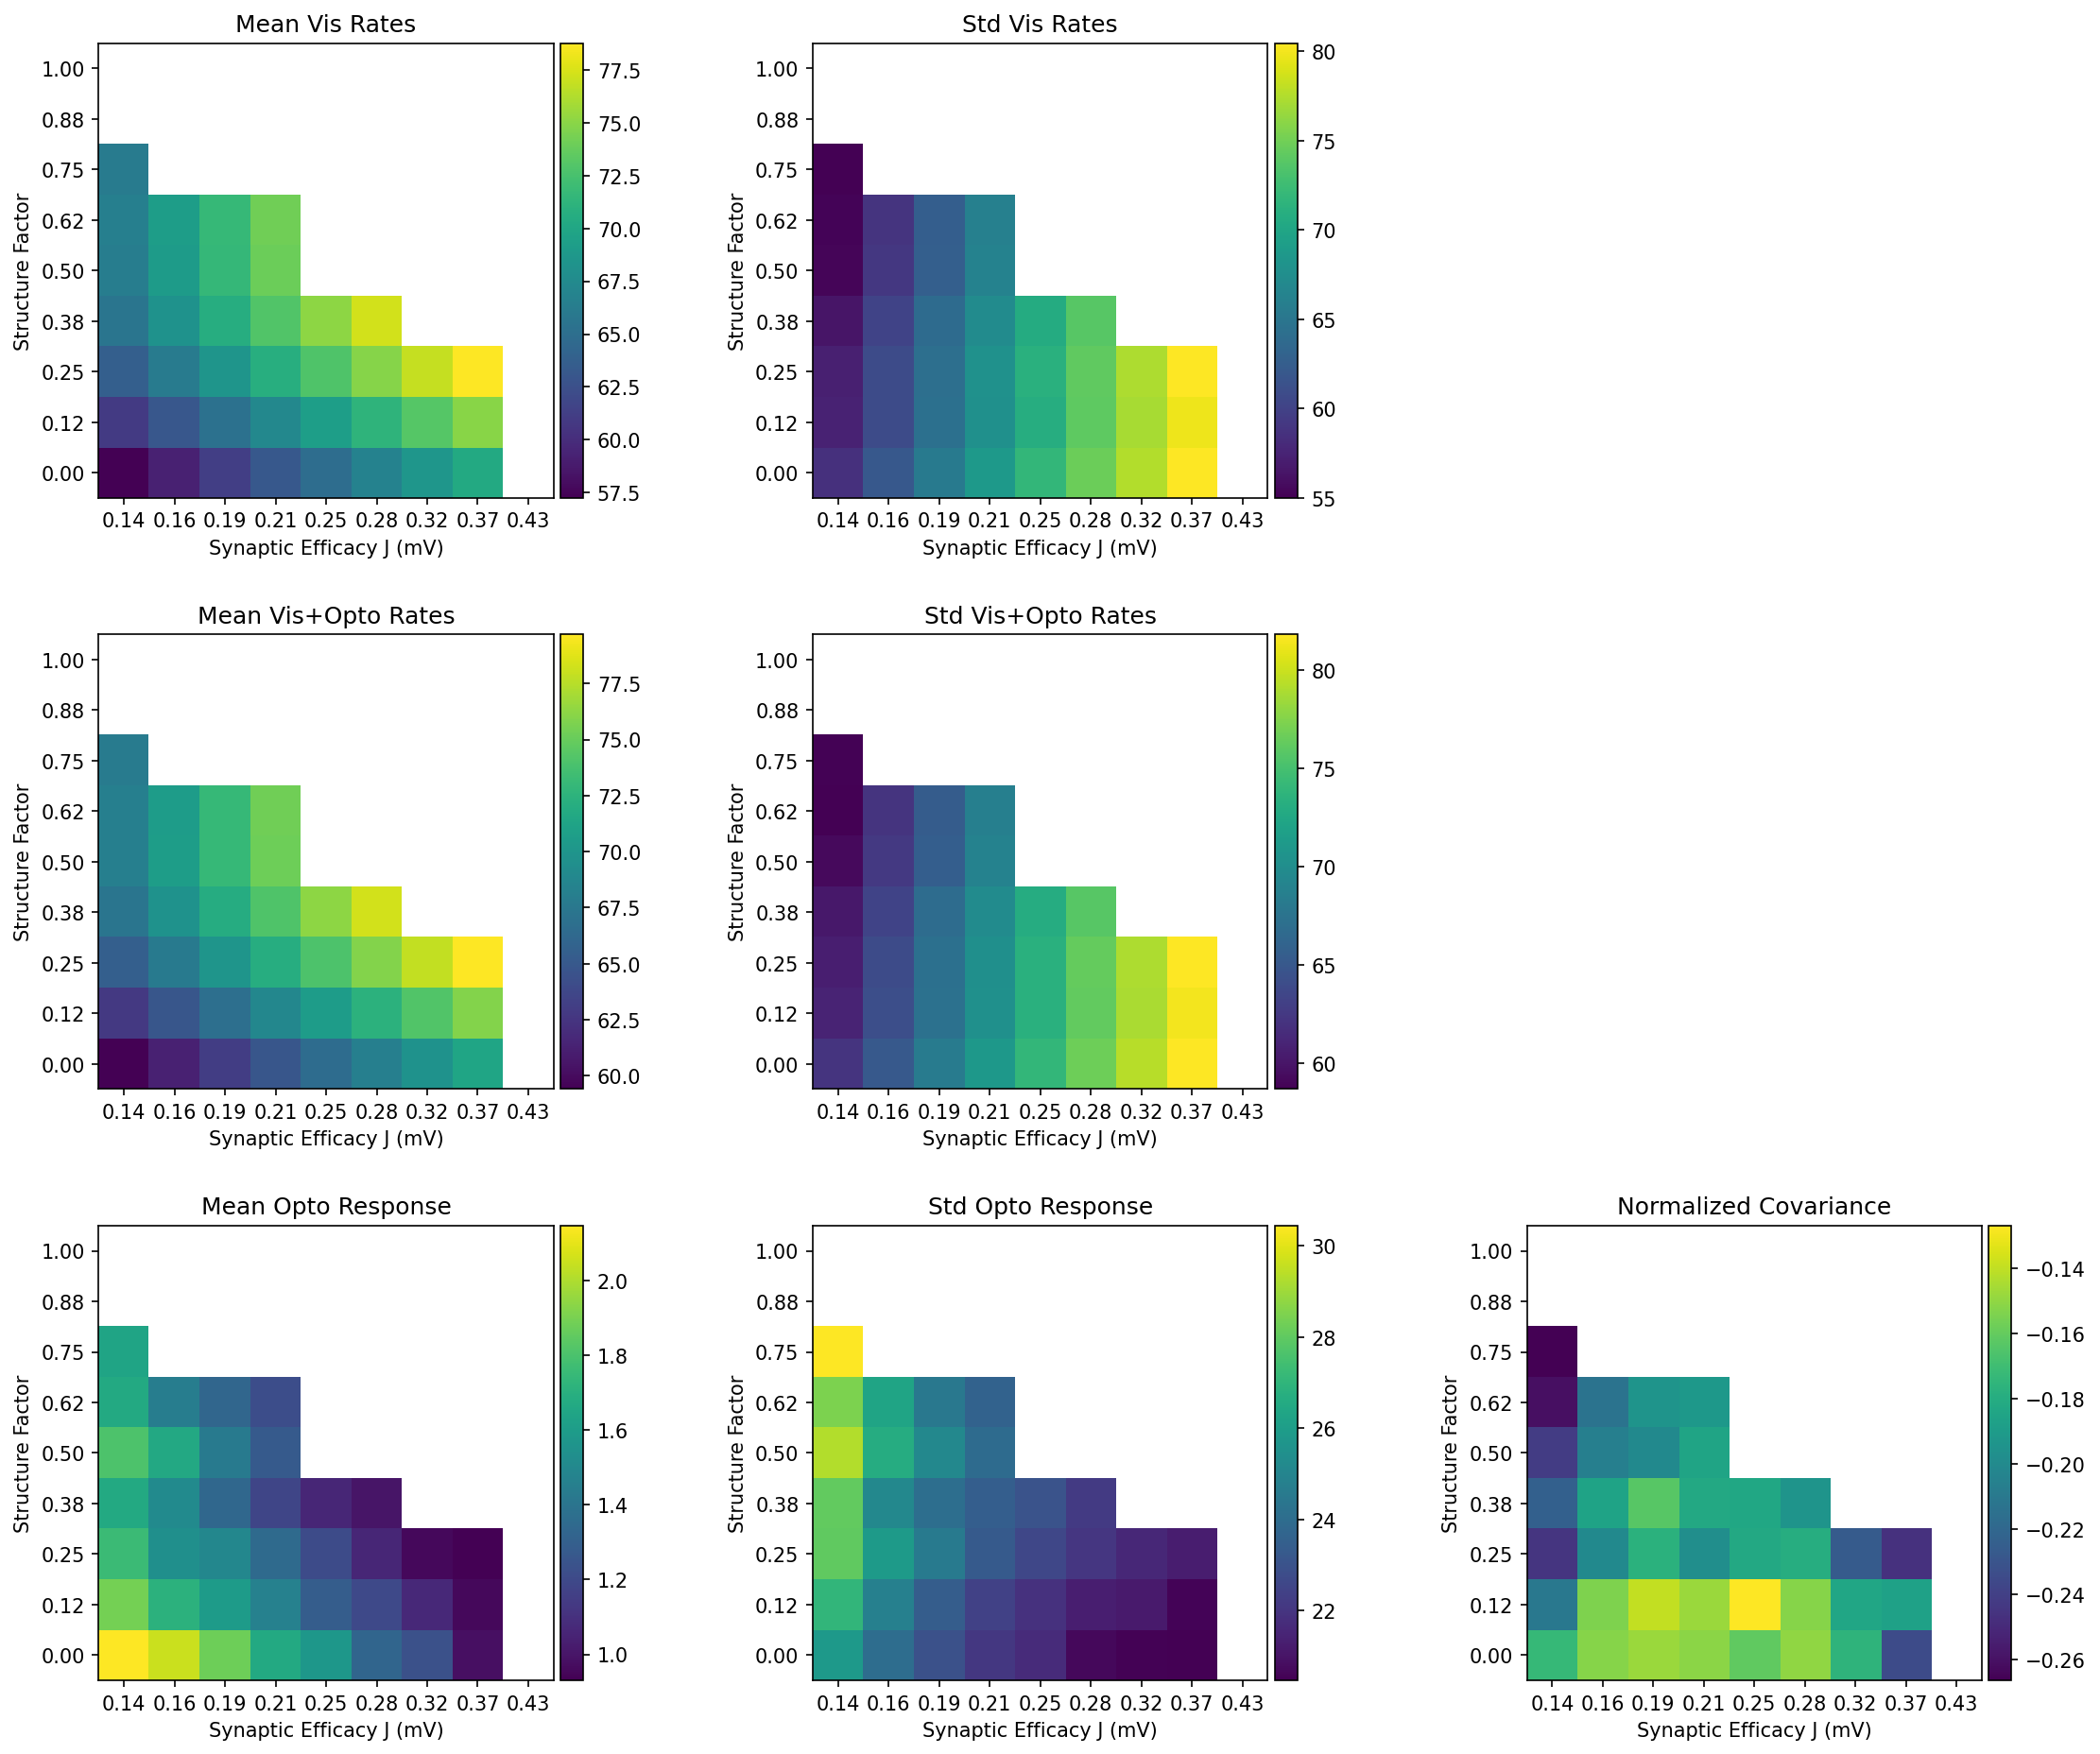

In [87]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],vsm_base_means,origin='lower')
imshowbar(fig,axs[0,1],vsm_base_stds,origin='lower')
imshowbar(fig,axs[1,0],vsm_opto_means,origin='lower')
imshowbar(fig,axs[1,1],vsm_opto_stds,origin='lower')
imshowbar(fig,axs[2,0],vsm_diff_means,origin='lower')
imshowbar(fig,axs[2,1],vsm_diff_stds,origin='lower')
imshowbar(fig,axs[2,2],vsm_norm_covs,origin='lower')

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
#             axs[i,j].contour(Lexps[:,:,0],[0],colors='w',linestyles='-')
#             axs[i,j].contourf(Lexps[:,:,0],[0,1e12],colors='w',linestyles='-',alpha=0.2)
#             axs[i,j].contour(Lexps[:,:,1],[0],colors='w',linestyles='--')
#             axs[i,j].contourf(Lexps[:,:,1],[0,1e12],colors='w',linestyles='--',alpha=0.2)
            
            axs[i,j].set_xticks(np.arange(len(Js)),['{:.2f}'.format(J*1000) for J in Js],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('Synaptic Efficacy J (mV)')
            axs[i,j].set_ylabel('Structure Factor')